In [2]:
import os
import pandas as pd
import pybedtools
from functools import reduce
from itertools import combinations
import matplotlib.pyplot as plt

#### GLOBALS ####
CURRENT_DIR_PATH = os.path.dirname(os.path.abspath("__file__"))
pybedtools.helpers.set_tempdir(CURRENT_DIR_PATH)

import upsetplot


In [3]:
lib_names = ["CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]
lib_response_files = [f"../data/{lib}/responsive.bed" for lib in lib_names]
lib_induced_files = [f"../data/{lib}/induced.bed" for lib in lib_names]
lib_repressed_files = [f"../data/{lib}/repressed.bed" for lib in lib_names]


In [4]:
def bedtools_add(a,b):
    return a+b

def bedtools_subtract(a,b):
    return a-b

def get_intersect_counts(include_beds, exclude_beds):
    intersect_bed = reduce(bedtools_add, include_beds)
    if len(exclude_beds)>0:
        exclude_beds = [intersect_bed] + exclude_beds
        intersect_bed = reduce(bedtools_subtract, exclude_beds)
    return intersect_bed.count()

def get_upset_df(lib_names, lib_files):
    peak_bed_dict = {ln: pybedtools.BedTool(pf) for ln,pf in zip(lib_names, lib_files)}
    peak_boolean_dict = {ln:[] for ln in lib_names}
    counts = []
    for i in range(1, len(lib_names) + 1):
        all_combos = list(combinations(lib_names, i))
        for combos in all_combos:
            include_combos = combos
            exclude_combos = [ln for ln in lib_names if ln not in include_combos]
            include_beds = [peak_bed_dict[c] for c in include_combos]
            exclude_beds = [peak_bed_dict[c] for c in exclude_combos]
            counts.append(get_intersect_counts(include_beds, exclude_beds))
            for c in include_combos:
                peak_boolean_dict[c].append(True)
            for c in exclude_combos:
                peak_boolean_dict[c].append(False)
    peak_boolean_dict["counts"] = counts
    df = pd.DataFrame(peak_boolean_dict)
    pybedtools.helpers.cleanup(remove_all=True)
    return df.set_index(lib_names)


In [15]:
upset_df = get_upset_df(lib_names[1:-1], lib_repressed_files[1:-1])

In [16]:
parsed_upset_df = upset_df.loc[upset_df.counts>1]

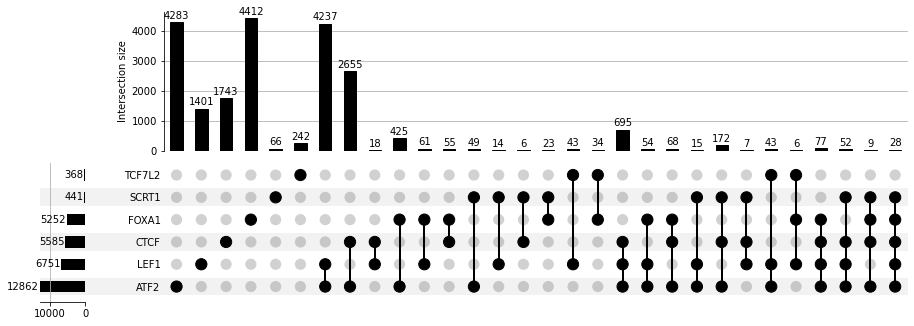

In [17]:
fig = upsetplot.plot(parsed_upset_df.counts, show_counts=True);